# **What is the role of nocturnal citral in the C3 leaf diel model ?**

# Part I - Modeling C3 leaf metabolism

## Step 1: Install cobrapy and retrieve files required to model C3 leaf metabolism
- Run `%pip install cobra` to install cobrapy
- Use wget using the syntax `!wget link-to-file` to retrieve the models and functions required for this analysis  

In [1]:
%pip install cobra==0.29.1 --quiet
!wget -q https://raw.githubusercontent.com/sshameer/DielLeafModeling/refs/heads/main/C3_model.sbml
!wget -q https://raw.githubusercontent.com/sshameer/DielLeafModeling/refs/heads/main/Functions.py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 38.9 MB/s eta 0:00:00


## Step 2: Read the model and perform pFBA  
- A cobra model can be generated from an SBML file using the `read_sbml_model` function in the cobrapy `io` module
- The syntax is `model_name = read_sbml_model(file_name)`
- pFBA can be performed using the `pfba` package in the cobrapy `flux_analysis` module
- The syntax is `solution_name = pfba(model_name)`
- The solution object has an attribute `fluxes` which containts a dictionary of all fluxes
- Check solution object for the flux representing nocturnal citrate accumulation i.e. `CIT_v_dielTransfer`


In [3]:
#import model
from cobra.io import read_sbml_model
model = read_sbml_model("C3_model.sbml")

#run pFBA and print citrate accumulation
from cobra.flux_analysis import pfba
sol1 = pfba(model)

print("Citrate accumulation rate =", round(sol1.fluxes["CIT_v_dielTransfer"],3))

Citrate accumulation rate = -0.298


## Step 3: Create a backup of the model
- to copy a cobra object using the `object.copy()` function

In [4]:
backup = model.copy()

## Step 4: Dowload Cytoscape to observe the PlantCoreMetabolism network
- Download Cytoscape from https://cytoscape.org/. This tutorial was tested on 3.10.1
- Download the [PlantCoreMetabolism Cytoscape session file](https://github.com/sshameer/DielLeafModeling/blob/main/PlantCoreMetabolism2.cys) and open it using Cytoscape
- The network has metabolite as circular nodes and reactions as smaller diamond shaped nodes. The colours represent different subcellular compartments (blue: cytosol, green: chloroplast, red: mitochondria, orange: peroxisome, purple: vacuole)

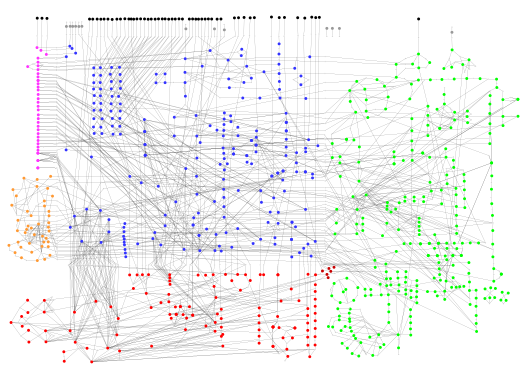

## Step 5: Use a function provided to generate mappings to visualize fluxes
- Use the `generateFluxMap` from `Functions.py` (which was retrieved in Step 1)
- The syntax for the function is `generateFluxMap(model_name, solution_name, output_file_name)`

In [8]:
from Functions import generateFluxMap
generateFluxMap(model,sol1,"C3Fluxes.tsv")

## Step 6: Visualize the fluxes in Cytoscape
- Download the flux mappings file generated by `generateFluMap` in the previous step
- Use `File > Import > Table from File...` to load the flux mappings


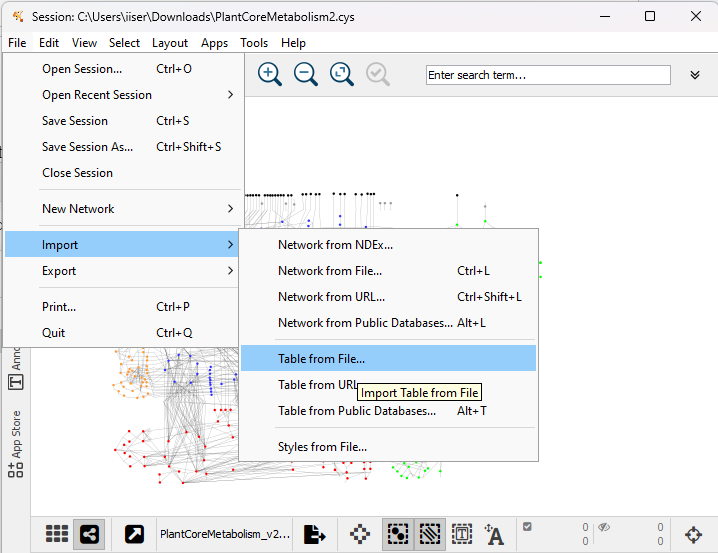

- In the `Import Columns from Table`, change `Key Column for Network` to `shared_name`
- Next open the `Advanced Options...` dialog and untick the `Use first line as column names` checkbox, and click the `OK` button
- The result should look like the image below with Column 1 having values for the reaction-reactant or reaction-product names; Column 2 and 4 having values for day-time and night-time fluxes, respectively; and Column 3 and 5 having values holding information on whether a metabolite is 'consumed' or 'produced' in the day and night reaction, respectively.

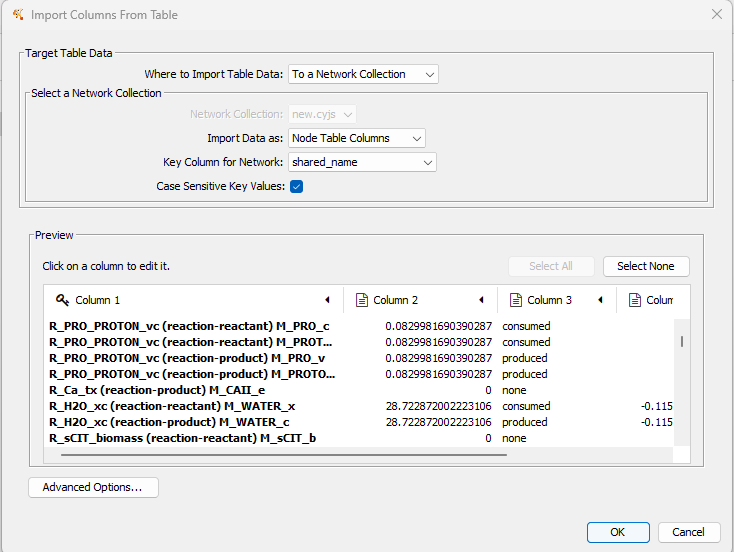

- From the `Style` tab, use the dropdown to select between the `Diel Day` and `Diel Night`

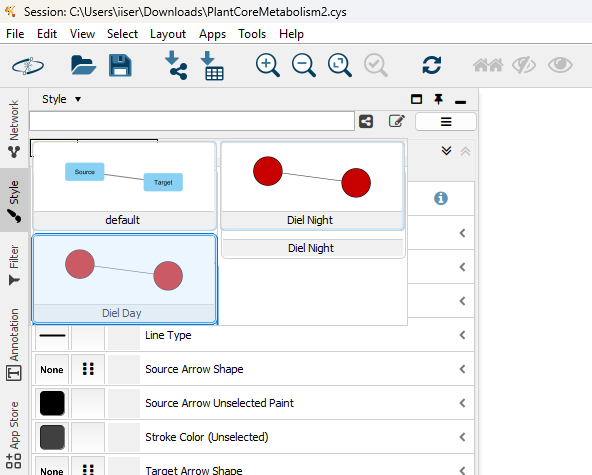

- Note that during the night citrate `CIT[v]`/`aCIT[v]` accumulates

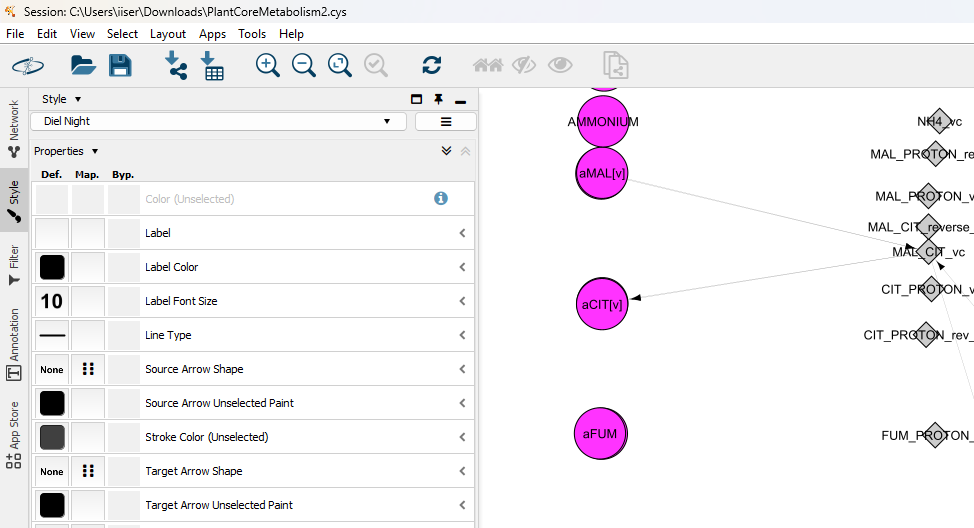

- Switch to the `Diel Day` style and track the `CIT[v]`/`aCIT[v]` flux to 2KG
- Extra: examine the network for the most significant fluxes in the network, do you recognize these fluxes?

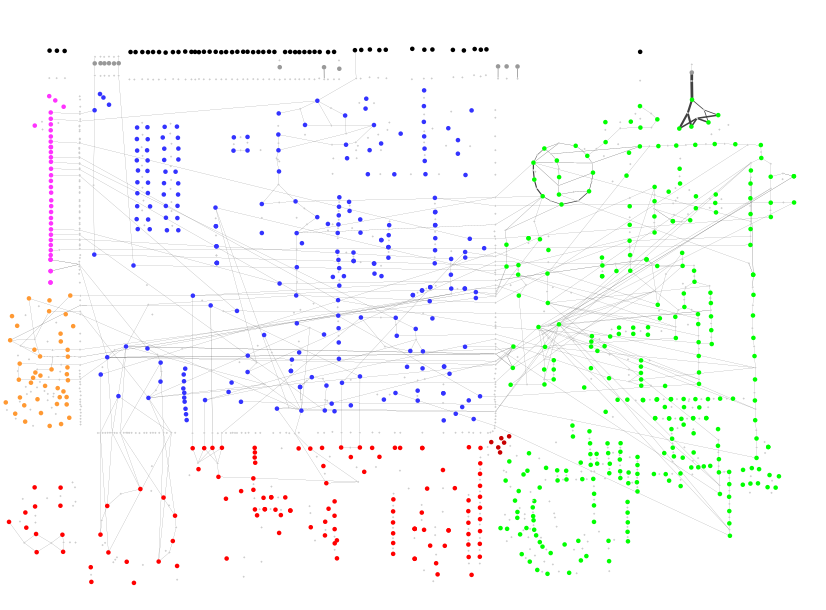

## *Tracking nocturnal CIT fluxes leads to 2KG and then GLT. In order to test if the only reason for nocturnal CIT accumulation is the amino acid synthesis required to meet the demand in phloem export, phloem composition can be updateed to only contain sucrose, and CIT accumulation flux can be checked*

# Part II - Test the hypothesis

## Step 1: Use the backup from earlier to restore the model to previous state

In [9]:
model = backup.copy()

# Step 2: Update the phloem composition
- Use the following code snippet to remove all metabolites except from sucrose and phloem from the phloem export reaction and print the final phloem composition
```
#removing all metabolites except Sucrose from phloem export
for rxn in model.reactions.query("Phloem_output_tx"):
  #first create a dictionary of all the metabolites to remove
  met2rem = dict()
  for met in rxn.metabolites.keys():
    if "SUCROSE" not in met.id and "X_Phloem_contribution_t" not in met.id:
      stoich = rxn.metabolites[met]
      met2rem[met]=stoich
  #for each metabolite in the met2rem, remove the metabolite from reaction
  for met in met2rem.keys():
    rxn.add_metabolites({met:-1*met2rem[met]})
  #Check if all amino acids have been removed from reaction
  print(rxn.reaction)
```

In [10]:
#removing all metabolites except Sucrose from phloem export
for rxn in model.reactions.query("Phloem_output_tx"):
  #first create a dictionary of all the metabolites to remove
  met2rem = dict()
  for met in rxn.metabolites.keys():
    if "SUCROSE" not in met.id and "X_Phloem_contribution_t" not in met.id:
      stoich = rxn.metabolites[met]
      met2rem[met]=stoich
  #for each metabolite in the met2rem, remove the metabolite from reaction
  for met in met2rem.keys():
    rxn.add_metabolites({met:-1*met2rem[met]})
  #Check if all amino acids have been removed from reaction
  print(rxn.reaction)

0.7326732673 sSUCROSE_b1 --> X_Phloem_contribution_t1
0.7326732673 sSUCROSE_b2 --> X_Phloem_contribution_t2


## Step 3: Run pFBA and check citrate accumulation again

In [11]:
#run pFBA and print citrate accumulation
sol2 = pfba(model)
print("Citrate accumulation rate =", round(sol2.fluxes["CIT_v_dielTransfer"],6))

Citrate accumulation rate = -0.0


## Step 4: Visualize flux distribution in Cytoscape as in Part I
- Check Citrate accumulation and remobilization fluxes in night and day phases respectively

In [13]:
generateFluxMap(model,sol2,"noAAinPhloem.tsv")

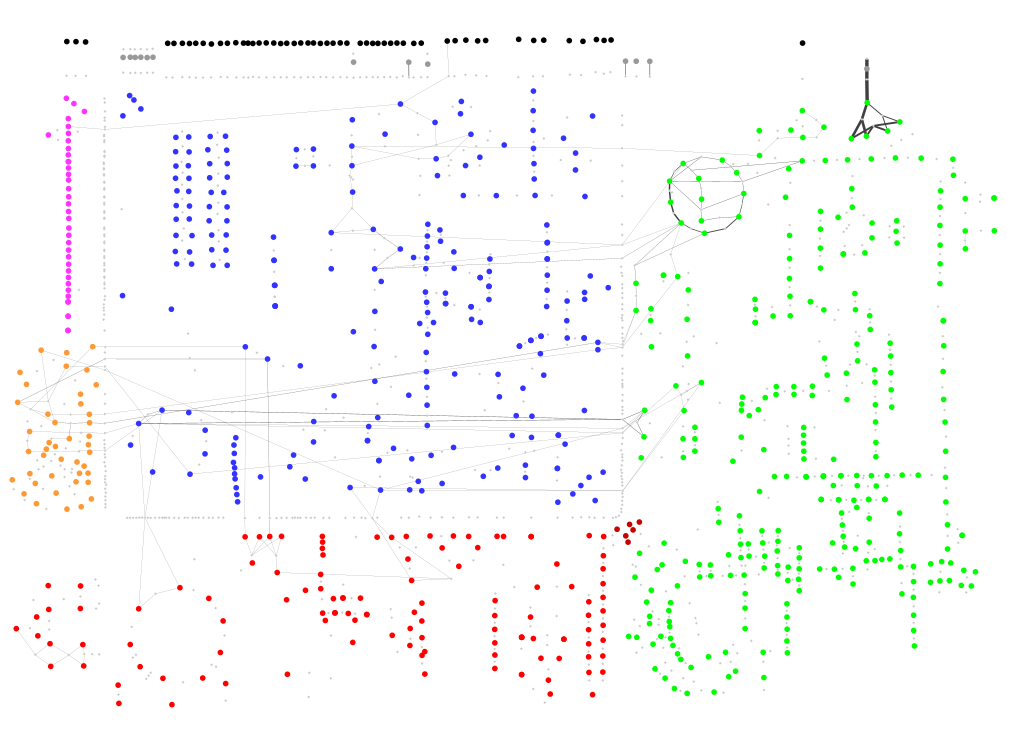

## *Note that there TCA cycle flux involving the conversion of CIT to 2KG is missing in the mitochondria. Nocturnal citrate accumulation disappears from the diel leaf FBA model when amino acids are no longer required for phloem export.*